# FA 2-Layer Network

**Ted Moskovitz, September 2017**

Backprop implementation with feedback alignment (see Nokland 2016, Lilicrap 2014 in Papers folder). Trained on MNIST.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as spm
import cPickle, gzip

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.size'] = 22

In [178]:
# Load the dataset
f = gzip.open('./Data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

In [179]:
X_train, y_train = train_set
X_val, y_val = valid_set
X_test, y_test = test_set

In [180]:
def convert_one_hot(labels, n_classes=10, th=False):
    oh_labels = np.zeros((len(labels), n_classes))
    if th:
        oh_labels.fill(-1.)
    for i in xrange(len(labels)):
        oh_labels[i,:][labels[i]] = 1.
    return oh_labels                       

In [181]:
y_train_oh = convert_one_hot(y_train)
y_val_oh = convert_one_hot(y_val)
y_test_oh = convert_one_hot(y_test)

In [182]:
# if no validation
y_train = np.reshape(np.vstack((y_train.reshape(50000,1), y_val.reshape(10000,1))), (60000,))
X_train = np.vstack((X_train, X_val))
y_train_oh = convert_one_hot(y_train)
print y_train.shape

(60000,)


In [183]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

In [185]:
epsinit = .01
eta = .005
decay = .000001

n0 = X_train.shape[1]
n1 = 50
n2 = 10


W1 = epsinit * np.random.randn(n1, n0)
b1 = epsinit * np.random.randn(n1, 1)

W2 = epsinit * np.random.randn(n2, n1)
b2 = epsinit * np.random.randn(n2, 1)

B = epsinit * np.random.randn(n1, n2) # FA, constant random matrix shape of W2.T

tmax = 2000000
tshow = 50000
loss = np.zeros((tmax,))
avgloss = np.zeros((tmax/tshow,))

mvalidate = len(y_val)
val_loss = np.zeros((tmax/tshow,))
errcl = np.zeros((tmax,))
avgerrcl = np.zeros((tmax/tshow,))

In [186]:
def get_minibatch(inp, targ, size):
    i = int(np.random.rand() * (len(targ) - size)) 
    return inp[i:i+size,:].T, targ[i:i+size]

In [187]:
def f(x):
    return 1. / (1. + np.exp(-x))
def df(y):
    return np.multiply(y, 1.-y)

In [188]:
def tanh(a):              # tanh activation function 
    return np.tanh(a) 
def dtanh(b):             # derivative of tanh
    return 1 - (b**2)

In [189]:
def soft(x):
    return np.log(1. + np.exp(x))
def dsoft(x): # unlike other deriv fns here, is wrt preactivation (u) not activation (x) 
    return f(x)

In [190]:
def spec_soft(x):
    a = 10.
    return (1./a)*np.log(1.+np.exp(a*x))
def dspec_soft(x):
    a = 10.
    return f(a*x)

In [191]:
def sq_loss(y, yhat, n):
    return sum(sum(np.power((y-yhat), 2))) / n

In [192]:
def poiss_loss(y, yhat, n):
    return np.mean(yhat - y * np.log(yhat + 1e-7) + np.log(spm.factorial(y)), axis=-1)

In [193]:
def neglogli(preds, actual):
    preds = np.reshape(preds, (-1,))
    nll = np.sum((preds - actual*np.log(preds + 1e-07) + np.log(spm.factorial(actual))))
    return nll

In [194]:
def predict(x0, wts, bs):
    W1, W2 = wts
    b1, b2 = bs
    
    sz = x0.shape[1]
    B1 = np.repeat(b1, sz).reshape([n1, sz])
    B2 = np.repeat(b2, sz).reshape([n2, sz])
    
    h = f(np.dot(W1,x0) + B1)
    preds = f(np.dot(W2,h) + B2)
    
    return preds

In [195]:
bsize = 16
predicted = np.zeros((tmax/tshow,bsize))
ys = np.zeros((tmax/tshow, bsize))
for t in xrange(tmax):
    x0, y = get_minibatch(X_train, y_train_oh, bsize)
    y = y.T
    
    B1 = np.repeat(b1, bsize).reshape([n1, bsize])
    B2 = np.repeat(b2, bsize).reshape([n2, bsize])
    
    # forward pass
    x1 = f(np.dot(W1,x0)+B1)
    u2 = np.dot(W2,x1)+B2
    x2 = f(u2)

    #loss[t] = sq_loss(y, x2, bsize)
    loss[t] = sq_loss(y, x2, bsize)
    
    errcl[t] = float(np.sum(np.argmax(x2,axis=0) != np.argmax(y,axis=0)))/bsize
    
    # backward pass
    #delta2 = (y - x2) * df(x2)
    delta2 = -np.multiply((1. - np.divide(y, x2+1e-7)), df(x2))
    
    delta1 = np.multiply(np.dot(B, delta2), df(x1)) # FA
    '''
    if (float(t)/tmax) == .75:
        print 'Learning Rate Annealed'
        eta /= 5.
    '''
    W2 += eta / bsize * np.dot(delta2, x1.T)
    W1 += eta / bsize * np.dot(delta1, x0.T)
    b2 += eta / bsize * np.sum(delta2, axis=1).reshape(n2, 1)
    b1 += eta / bsize * np.sum(delta1, axis=1).reshape(n1, 1)
    
    eta *= (1.-decay) 
    
    if t % tshow == 0 and t > 0:
        print 'Epoch ' + str(t/tshow) + ' of ' + str(tmax/tshow-1) + ':'
    
        avgloss[t/tshow-1] = np.sum(loss[:t]) / float(t+1)
        avgerrcl[t/tshow-1] = np.sum(errcl[:t]) / float(t)
        #predicted[t/tshow-1,:] = x2
        #ys[t/tshow-1,:] = y
        print "Avg. Train Loss: " + str(avgloss[t/tshow-1])
        print 'Avg. Class Error: ' + str(avgerrcl[t/tshow-1])
        
        '''
        # validation loss
        x0 = X_val.T
        
        B1 = np.repeat(b1, mvalidate).reshape([n1, mvalidate])
        B2 = np.repeat(b2, mvalidate).reshape([n2, mvalidate])
        x1 = f(np.dot(W1,x0)+B1)
        x2 = f(np.dot(W2,x1)+B2)
        
        #val_loss[t/tshow-1] = sq_loss(y_val.T, x2, mvalidate)
        val_loss[t/tshow-1] = sq_loss(y_val_oh.T, x2, mvalidate)
        
        print "Validation Loss: " + str(val_loss[t/tshow-1])
        '''
        print ' '
        
        

Epoch 1 of 39:
Avg. Train Loss: 0.700808162314
Avg. Class Error: 0.378795
 
Epoch 2 of 39:
Avg. Train Loss: 0.558306452098
Avg. Class Error: 0.275686875
 
Epoch 3 of 39:
Avg. Train Loss: 0.483734596956
Avg. Class Error: 0.232575416667
 
Epoch 4 of 39:
Avg. Train Loss: 0.436811999419
Avg. Class Error: 0.2079459375
 
Epoch 5 of 39:
Avg. Train Loss: 0.403892164204
Avg. Class Error: 0.19165
 
Epoch 6 of 39:
Avg. Train Loss: 0.379517201734
Avg. Class Error: 0.180115
 
Epoch 7 of 39:
Avg. Train Loss: 0.36057784899
Avg. Class Error: 0.171340178571
 
Epoch 8 of 39:
Avg. Train Loss: 0.345376570696
Avg. Class Error: 0.164490625
 
Epoch 9 of 39:
Avg. Train Loss: 0.332824539458
Avg. Class Error: 0.158914444444
 
Epoch 10 of 39:
Avg. Train Loss: 0.322297242533
Avg. Class Error: 0.154256
 
Epoch 11 of 39:
Avg. Train Loss: 0.313349800998
Avg. Class Error: 0.150390454545
 
Epoch 12 of 39:
Avg. Train Loss: 0.305596417778
Avg. Class Error: 0.147051041667
 
Epoch 13 of 39:
Avg. Train Loss: 0.298806668027

In [ ]:
w1 = np.mean(W1, axis=0)
print w1.shape
plt.plot(w1)
plt.show()

In [ ]:
for i in xrange(n1):
    plt.plot(W1[i,:])
    plt.show()

In [ ]:
plt.plot(ys[0,:], label='target')
plt.plot(predicted[0,:], label='prediction')
plt.legend()
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Initial')
plt.show()

In [ ]:
plt.plot(ys[-2,:], label='target')
plt.plot(predicted[-2,:], label='prediction')
plt.legend()
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Final')
plt.show()

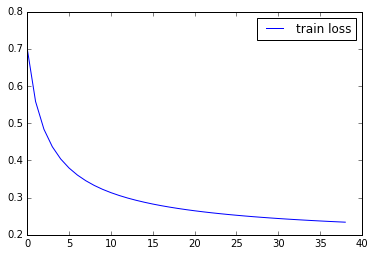

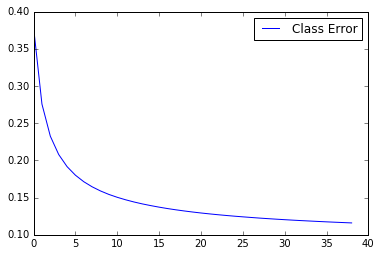

In [196]:
plt.plot(avgloss[:-1], label='train loss')
#plt.plot(val_loss[:-1], label='validation loss')
plt.legend()
plt.show()

plt.plot(avgerrcl[:-1], label='Class Error')
np.savetxt('./Results/MLP_FA_784_50_10_classerr.csv', avgerrcl[:-1], delimiter=',')
plt.legend()
plt.show()

In [ ]:
print W1.shape
print W2.shape
print b1.shape
print b2.shape

In [128]:
wts = (W1, W2)
bs = (b1, b2)
preds = predict(X_test.T, wts, bs)
print preds.shape

print sq_loss(y_test_oh.T, preds, num_test)

print float(np.sum(np.argmax(preds,axis=0) != np.argmax(y_test_oh.T, axis=0))) / num_test

(10, 10000)
0.167132507017
0.0859


In [ ]:
r = int(np.random.rand() * len(y_test)) 
if r > 1000:
    r = r - 20
plt.plot(y_test[r:r+20], label='target')
plt.plot(predict(X_test[r:r+20,:].T, wts, bs).T, label='prediction')
plt.legend()
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Test Points')
plt.show()

In [ ]:
B1 = np.repeat(b1, num_train).reshape([n1, num_train])
B2 = np.repeat(b2, num_train).reshape([n2, num_train])
filt_output0 = np.dot(W2, f(np.dot(W1, X_train.T) + B1)) + B2
#filt_output0 = np.dot(W1, X_train.T) + B1
print filt_output0.shape

In [ ]:
h1, bin_edges = np.histogram(filt_output0[0,:], bins=20)
plt.hist(filt_output0[0,:], bins=20)
plt.show()

In [ ]:
train_preds = predict(X_train.T, wts, bs)
train_preds = train_preds.T
print train_preds.shape